# Generative Adverserial Networks - GAN

### 1. Początki

Twórcą modelu sieci generatywnych jest Ian Goodfellow - obecny szef działu Uczenia Maszynowego w Apple. W swojej pracy z 2014 roku (https://arxiv.org/pdf/1406.2661.pdf) zaproponował on system dwóch sieci neuronowych, w ramach gry typu `mini-max` jedna z sieci nazywana `generatorem` uczy się tworzyć nowe próbki danych, podczas gdy druga sieć - `dyskryminator` uczy się rozpoznawać czy dane zdjęcie pochodzi ze zbioru uczącego czy jest podróbką od generatora. W ramach treningu generator staję się coraz lepszy w "oszukiwaniu" dyskryminatora.

### 2. Architektura i sposób działania

#### 2.1 Dyskryminator 

Jest on "standardową" splotową/konwolucyjną siecią neuronową. Na swoje wejście przyjmuje dwa elementy, jeden po drugim - próbkę danych (batch) pochodzącą ze `zbioru treningowego`, a następnie próbkę `wygenerowanych` przykładów przez `generator` - $G(z)$.

<img src="./d.PNG">

Jego zadaniem jest ocena prawdopodobieństwa, czy dany przykład jest fałszywką czy nie. Jako, że jest to problem natury binarnej możemy wykorzystać krzyżową entropię binarną jak funkcję straty (`binary_crossentropy`). Funkcja straty jest ujemną sumą prawdopodobieństwa, że dana próbka jest `prawdziwa - D(x)` oraz `1 - prawdopodobieństwo poprawnego` sklasyfikowania `syntetycznej próbki -- 1 - D(G(z))`: 

$$L^D (\theta^G, \theta^D) = -E_{x--p_data} \log{D(x)} - E_z\log{1- D(G(z))}$$ 

W celu zminimalizowania funkcji straty, parametry dyskryminatora $\theta^D$ będą aktualizowane za pomocą metody `wstecznej propagacji gradientów (backpropagation)`. 
Poprawna klasyfikacja danych pochodzących ze zbioru uczącego oznacza, że prawdopodobieństwo $D(x)$ dążyć będzie do 1:

$$D(x) \rightarrow 1$$

Poprawna klasyfikacja zdjęć pochodzących od `generatora` oznacza, że:

$$1 - D(G(z)) \rightarrow 1$$ lub
$$D(G(z)) \rightarrow 0$$

## 2.2 Generator 

Może wydawać się nietypowem modelem sieci neuronowych. Jest on dokładnym przeciwieństwem `dyskryminatora`. Podczas gdy dyskryminator `redukuje` ilość informacji, wyciagając z podanego zdjęcia wartość semantyczną. Generator z drugiej strony ma za zadanie zwiększyć wymiarowość danych - sprowadzić informację od poziomu `wektora` do poziomu macierzy określonych rozmiarów (zdjęcia). Głównymi operacjami stosowanymi do tego rodzaju zadań są:

 - `UpSampling2D`,
 - `Conv2DTransposed`
 
 
Różnica pomiędzy tymi dwoma jest znacząca. Pierwsza metoda rzeczywiście powiększa rozmiar macierzy dwukrotnie, jednakże robi to "mechanicznie" - nie posiada żadnych parametrów, które można by było wykorzystać w procesie uczenia. Przykład:



$$
\begin{bmatrix} 1 & 2 \\ 3 & 4 \end{bmatrix} \rightarrow \begin{bmatrix} 1 & 1 & 2 & 2 \\  1 & 1 & 2 & 2 \\ 3 & 3 & 4 & 4 \\ 4 & 4 & 4 & 4 \end{bmatrix}
$$

Metoda dekonwolucji zakłada parametr uczący (wagę), która może być optymalizowana w trakcie uczenia. Kluczowym pomysłem jest tutaj wykorzystanie parametru `stride = (2,2)`. Symbolizuje on odstęp/krok o jaki przesuwamy `filtr` w danej warstwie. Duży stride oznacza małe mapy cech, mały - duże. Poniżej zaprezentowana jest sytuacja, w której mapę cech o rozmiarach 2x2 (tak jak wyżej) przekształcimy w macierz 4x4 (tak jak wyżej) przy użyciu filtra `1x1` z wagą równą 2.0 oraz `bias-em` równym 0.0.

$$
\begin{bmatrix} 1 & 2 \\ 3 & 4 \end{bmatrix} * (w=2.0, b=0) \rightarrow \begin{bmatrix} (1*2.0) & 0 & (2*2.0) & 0 \\ 0 & 0 & 0 & 0 \\ (3*2.0) & 0 & (4 * 2.0) & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix} \rightarrow \begin{bmatrix} 2 & 0 & 4 & 0 \\ 0 & 0 & 0 & 0 \\ 6 & 0 & 8 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix}
$$


Aby wytrenować `generator`, bierzemy nasze dwie sieci i traktujemy ich funkcje straty jako grę o zerowej sumie końcowej (`zero-sum-game`), która oznacza po prostu, że sukces jednej sieci oznacza porażkę drugiej. Funkcja straty generatora jest `negacją` funkcji straty dyskryminatora - z punktu widzenia generatora chcemy ją ($L^G$) `minimalizować`, natomiast z punktu widzenia dyskryminatora `maksymalizować`. Z punktu widzenia generatora, chcemy sprawić aby generator był jak `najmniej` pewny swojej decyzji.

$$
L^G (\theta^G, \theta^D) = - L^D (\theta^G, \theta^D)
$$

Generator na swoje wejście przyjmuje wektor, o określonej przez twórcę długości, najcześciej generowany z rozkładu normalnego. Na jego podstawie tworzone jest zdjęcie podawane na wejście dyskryminatora. 

<img src="./g.PNG">

### 2.3 GAN

W trakcie uczenia na zmianę uczony aktualizowane jest generator jak i dyskryminator. W czasie zmiany wag generatora, wagi dyskryminatora zostją `zamrożone`.
<img src="./ggg.PNG">

Niestety, trenowanie tego rodzaju sieci jest nie tylko kosztowne obliczeniowo ale także niezwykle trudne ponieważ sam proces optymalizacji jest wysoce `niestabilny` ! Ponadto istnieje także problem znany jako `mode collapse` - jest to sytuacja gdzie generator tworzy to samo zdjęcie bądź szum, którym jest w stanie zmylić dyskryminator w kółko. Nim badacze osiągneli to co dziś uznajemy za `state-of-the-art` musieli się najpierw zmierzyć z szeregiem problemów dotyczących właśnie procesu optymalizacji. Jedną z pierwszych, przełomowych prac na ten temat było tzw. `DCGAN` - Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, autorstwa Alec Radford, Luke Metz oraz Soumith Chintala. W wymienionej pracy badacze eksperymentowali z różnymi wersjami sieci generatywnych, stosując rozmaite kombinacje hiperparametrów. Cała praca jest zestawieniem ich najlepszych rad w ramach budowy sieci GAN, ponadto jeden z twórców w.w. pracy napiasł także artykuł sugerujący jak trenować takie sieci. Zestaw tych wszystkich "pro-tipów" został zaprezentowany poniżej

- Zastąp warstwy "pooling" na "strided-convolution" (D) oraz wykorzystywać "fractional-strided-convolution" (G),
- Wykorzystuj normalizację paczki (BatchNormalization) zarówno w D jak i G,
- Usuń warstwy gęste (warstwy neuronalne) i zastąp je warstwami splotowymi,
- Używaj funkcji aktywacji znanej jako LeakyReLu,
- Z optymalizatorów wybierz "Adam",
- W generatorze, ostaniej warstwie, wykorzytaj funkcję aktywacji - tangens hiperboliczny (tanh)
- Wykorzystuj zaszumione etykiety - podawać fałszywe etykiety wzorcowe dla dyskryminatora tak aby zachęcić go do popełnienia błędu (co może pomóc generatorowi).

Niemniej jednak to podejście nie rozwiewa wszystkich problemów, jednakże jest to świetny punkt startowy. W poniższym notebook'u zaimplementowany został DCGAN stosując niektóre z w.w. porad dla problemu generacji twarzy.

## 3.3 DCGAN dla Celeb A

W ramach tego notebook'a zaimplementowany zostanie DCGAN dla zbioru danych Celeb A, zawierajacy zdjęcia twarzy celebrytów. Zbiór danych dostępny jest pod adresem: https://www.kaggle.com/jessicali9530/celeba-dataset?select=img_align_celeba

W trakcie tego projektu będziemy wykorzystywać także algorytm kaskadowych cech haara - elementy do pobrania znajdują się na stronie: http://alereimondo.no-ip.org/OpenCV/34/ - frontalFace10.zip. Zawartość tego zipa prosimy wypakować do folderu (pod nazwą "haars") z bieżącym notebookiem oraz zdjęciami celebrytów.

#### Import bibliotek

In [1]:
# Import bibliotek
import os # scieżki do plików
import random
import numpy as np # liniowa algebra 
import matplotlib.pyplot as plt # wyświetlanie danych
import cv2 # przetwarzanie obrazów
import tensorflow.keras.layers as kl # warstwy funkcjonalne
import tensorflow.keras.callbacks as kc # funkcje wspomagające
import tensorflow.keras.backend as K # przetwarzenie tensoryczne
import tensorflow.keras.optimizers as ko # optymalizatory
from tensorflow.keras.models import Model, load_model # konstrukacja modelu
from tensorflow.keras.utils import plot_model
from tqdm import tqdm # ładny progress bar
from tensorflow.compat.v1 import ConfigProto # ustawienia gpu
from tensorflow.compat.v1 import InteractiveSession # ustawienia gpu

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.65
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


%matplotlib inline

#### Zdefiniowanie scieżki oraz metod potrzebnych do preprocessing-u danych

In [2]:
dataset_path = os.path.join(os.getcwd(), 'dataset') # sciezka do folderu ze zdjęciami celebrytów
print(f"Liczba obrazów w zbiorze treningowym: {len(list(os.listdir(dataset_path)))}")

Liczba obrazów w zbiorze treningowym: 202599


In [3]:
def read_images(path:str, limit:int=0):
    """
    Metoda wczytująca obraz podanej scieżki. Ilość wczytanych obrazów zależy od zdefiniowanego parametru limit
    """
    
    images = [] # inicjalizacja tablicy na zdjęcia
    
    for fname in tqdm(os.listdir(path)):
        fpath = os.path.join(path, fname) # ścieżka do konkretnego zdjęcia
        img = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB) # wczytanie oraz konwersja obrazu z przestrzeni BGR->RGB
        if limit !=0 and limit == int(len(images)): # warunek limitujący
            return images
        images.append(img)
        
    return images

def check_shape(images:list, shape=(160,160,3)):
    """
    Metoda weryfikująca czy obrazy w podanej liście mają określony przez parametr 'shape' kształt
    """
    counter = 0
    for img in images:
        if img.shape != shape:
            print("Obrazy są różnego kształtu ;(!")
            counter +=1
        
def plot_images(images:list,n:int):
    """
    Metoda wyświetlajaca dane z podanej listy. Ilość przykładów do wyrysowania - n*n
    
    """
    plt.figure(figsize=(15,15))
    for i in range(n**2):
        plt.subplot(n,n,1+i)
        plt.axis("off")
        plt.imshow(images[i])
        
    plt.show()
    
def change_size(images:list, size:tuple):
    
    """
    Metoda pozwalająca na zmianę rozmiaru zdjęcia przy pomocy interpolacji bikubicznej.
    
    """
    new_images = []
    for img in images:
        img = cv2.resize(np.array(img), (size[1],size[0]), cv2.INTER_CUBIC)
        new_images.append(img)
    
    return new_images

def crop_imgs(images:list):
    
    """
    Metoda wykorzystuje algorytm cech Haar'a tak aby wyodrębnić twarz z podanych zdjęć. Odrzucane są zdjęcia na których zostanie wykryte więcej/mniej twarzy niż jedna.
    """
    faces = []
    cascade_path = os.path.join(os.getcwd(), 'haars/haarcascade_frontalface_alt.xml')
    face_cascade = cv2.CascadeClassifier(cascade_path)
    
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        face = face_cascade.detectMultiScale(gray, 1.3,5) #detekcja twarzy
        
        if len(face) == 1:
            (x,y,w,h) = face[0] # koordynaty twarzy
            roi_color = img[y:y+h, x:x+h] # wydzielenie obszaru z twarzą
            faces.append(roi_color)
    
    print("Number of faces detected: ", len(faces))
    return faces

def normalize_imgs(images:np.array):
    """
    Normalizacja obrazów do przedziału <-1,1> - w celu wykorzystania tangensa hiperbolicznego w generatorze
    """
    
    images = images.astype('float32')
    images = (images - 127.5) / 127.5
    return images


  2%|█▎                                                                        | 3500/202599 [00:03<03:17, 1009.13it/s]


Number of faces detected:  3015


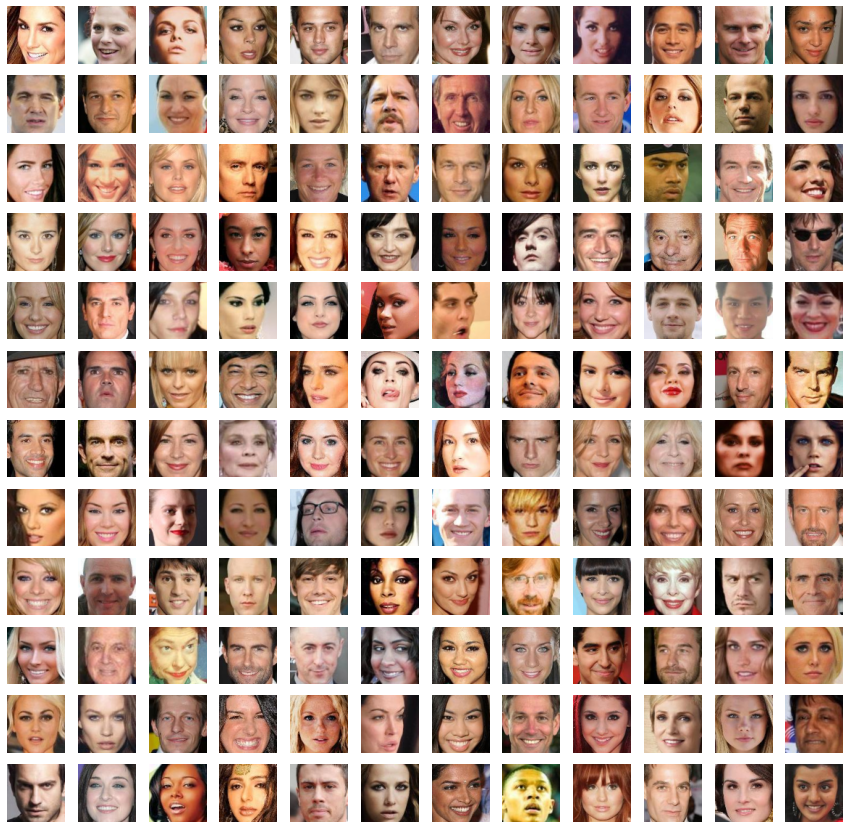

In [4]:
SHAPE = (80,80,3) # kształt obrazów jaki będzie podawany do dyskryminatora oraz jaki będzie generowany przez generator

imgs = read_images(dataset_path,3500) # wczytujemy pierwsze n obrazów z folderu
faces = crop_imgs(imgs) # wycinamy twarz przy pomocy detektora Haar'a
del imgs # usuwamy niepotrzebnie zajmujące pamięć obrazy

faces = change_size(faces,size=SHAPE) # zmieniamy rozmiar wyciętych twarzy
check_shape(faces, SHAPE) # sprawdzamy czy wszystko się zgadza
plot_images(faces,12) # pokazujem 144 zdjęcia

In [5]:
faces = normalize_imgs(np.array(faces)) # normalizacja zdjęć do przedziału <-1,1>

#### Definicja modeli i funkcji pomocniczych

In [6]:
def build_discriminator(input_size:tuple):
    
    """
    Definiuje dyskryminator, który na swoje wejście przyjmuje obrazy o zdefiniowanym kształcie "SHAPE" oraz aplikuje kolejne warstwy splotowe w celu wyciągnięcia cech i klasyfikacji obrazów.
    Do jakiego stworzenia wykorzystujemy funkcjonalne API Keras'a
    """
    
    inputs = kl.Input(shape=input_size)  # warstwa wejściowa
    x = kl.Conv2D(128,(4,4), padding='same', input_shape=input_size)(inputs) # 64
    x = kl.LeakyReLU(alpha=0.2)(x)  
    
    x = kl.Conv2D(128,(4,4), padding='same')(x)
    x = kl.LeakyReLU(alpha=0.2)(x)
    
    x = kl.Conv2D(128,(4,4), padding='same')(x)
    x = kl.LeakyReLU(alpha=0.2)(x)
    
    x = kl.Conv2D(128,(4,4), padding='same')(x)
    x = kl.LeakyReLU(alpha=0.2)(x)
    
    x = kl.Conv2D(128,(4,4), padding='same')(x)
    x = kl.LeakyReLU(alpha=0.2)(x)
    
    x = kl.Flatten()(x)
    x = kl.Dropout(0.4)(x)
    x = kl.Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator
    

In [7]:
def build_generator(latent_dim:int):
    
    """
    Tworzymy architekturę Generatora. Wykorzystując Conv2DTransposed jesteśmy w stanie zwiększać rozmiar mapy cech.
    """
    
    inputs = kl.Input(shape=(latent_dim,))
    n_nodes = 5 * 5 * 128
    filter_size = (4,4)
    
    x = kl.Dense(n_nodes)(inputs)
    x = kl.LeakyReLU(alpha=0.2)(x)
    x = kl.Reshape((5,5, 128))(x)
    
    
    x = kl.Conv2DTranspose(128, filter_size, strides=(2,2), padding='same')(x)
    x = kl.LeakyReLU(alpha=0.2)(x)
    
    x = kl.Conv2DTranspose(128, filter_size, strides=(2,2), padding='same')(x)
    x = kl.LeakyReLU(alpha=0.2)(x)
    x = kl.BatchNormalization()(x)
    
    x = kl.Conv2DTranspose(128, filter_size, strides=(2,2), padding='same')(x)
    x = kl.LeakyReLU(alpha=0.2)(x)
    x = kl.BatchNormalization()(x)
    
    x = kl.Conv2DTranspose(128, filter_size, strides=(2,2), padding='same')(x)
    x = kl.LeakyReLU(alpha=0.2)(x)
    
    x = kl.Conv2D(3,(5,5), activation='tanh', padding='same')(x)
    
    generator = Model(inputs, x, name='generator')
    return generator

In [8]:


def save_images(epoch,imgs):
    """
    Metoda zapisująca próbki obrazów powstałe w procesie uczenia
    """
    
    # Przeskaluj na 0-1
    imgs = 0.5 * imgs + 0.5
    
    fig, axs = plt.subplots(rows, cols,figsize=(15,15))
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(SHAPE))
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()
    
def noisy_labels(labels, fake_label:int, percentage:float=0.3):
    
    """
    Metoda podmieniająca etykiety na fałszywe w stopnie=u "percentage"
    """
    
    nb_labels = int(percentage * len(labels))
    indexes = list(np.random.randint(0,len(labels), nb_labels))
    counter=0
    
    for label in labels:
        
        if counter != nb_labels:
                
            labels[indexes[counter]] = fake_label
            counter+=1
        else:
            #print("Number of ones: " ,np.count_nonzero(labels))
            #print("Number of zeros: ", (len(labels)- np.count_nonzero(labels)))
            return labels
            

In [9]:
D = build_discriminator(input_size=SHAPE) # zbudowanie modelu
plot_model(D,'./discriminator.png') # zapisanie architektury do pliku
D.summary() # wyswietlenie podsumowania

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 128)       6272      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 128)       262272    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 80, 80, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 80, 80, 128)     

In [10]:
latent_dim = 100 # wektor wejściowy do generatora -  arbitralne
G = build_generator(latent_dim) 
plot_model(G,'./generator.png') 
G.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3200)              323200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 128)       26

#### Kompilacja modelu, definicja uczenia i pętla ucząca

In [11]:
batch_size = 32 # rozmiar próbki/paczki
epochs = 50000 # ilość iteracji po batchach (technicznie nie epoka)
sample_period = 200 # zapisujemy zdjecia co "sample period"
learning_rate_D = 0.0002 # learning rate dla dyskryminatora
learning_rate_G = 0.0002 # learning rate dla generatora

ones =  np.ones(batch_size) # generujemy wartości wzorcowe dla zbioru treningowego
zeros = np.zeros(batch_size) # wartości wzorcowe dla danych od generatora

D.compile(loss='binary_crossentropy',
          optimizer=ko.Adam(learning_rate_D,0.5),
          metrics=['accuracy'])  # kompilujemy dyskryminator 

z = kl.Input(shape=(latent_dim,)) # reprezentujemy szum jak warstwę wejściową do generatora
img = G(z) # generujemy obraz

D.trainable = False #zamrażamy warstwy
fake_pred = D(img) # predykcja na dyskryminatorze

full_model = Model(z, fake_pred) # dla generatora - tworzymy kompozyt modelu!
full_model.compile(loss='binary_crossentropy', optimizer=ko.Adam(learning_rate_G,0.5)) # kompilujemy

d_losses = [] # przechowywalnia dla funkcji straty dyskryminatora
g_losses = [] # przechowywalnia dla funkcji straty generatora

# Utworzenie folderu gdzie będą się znajdować generowane zdjęcia
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [12]:
#pętla ucząca
count = 0
for epoch in range(epochs):
    
    noisy_ones = noisy_labels(ones,0,0.2).astype('float32').reshape(-1,1) # szum w etykietach 
    noisy_zeros = noisy_labels(zeros,1,0.2).astype('float32').reshape(-1,1) # szum w etykietach
    
    idx = np.random.randint(0, faces.shape[0], batch_size) # bierzemy pseudo-przypadkową próbkę ze zbioru treningowego
    real_imgs = faces[idx] # paczka prawdziwych obrazów
     
    noise = np.random.randn(batch_size, latent_dim) # generujemy rzeczywisty szum
    fake_imgs = G.predict(noise) # generujemy zdjecia przy pomocy generatora
    
    
    dloss_real, dacc_real = D.train_on_batch(real_imgs, noisy_ones) # trenujemy dyskryminator na paczce danych ze zbioru 
    dloss_fake, dacc_fake = D.train_on_batch(fake_imgs, noisy_zeros) # trenujemy dyskryminator na paczce danych z generatora
    
    dloss = 0.5 * (dloss_real + dloss_fake) # średnia z funkcji strat
    dacc = 0.5 * (dacc_real + dacc_fake) # średnia ze skuteczności
    
    #trening generatora
    
    for i in range(0,2):
        noise = np.random.randn(batch_size, latent_dim) # generujemy ponownie wektor szumu
        gloss = full_model.train_on_batch(noise, ones) # trenujemy generator poprzez łączony model
    
    #zapisujemy straty
    d_losses.append(dloss) 
    g_losses.append(gloss)
    
    
    if epoch >= 45000:
        if epoch % 500 == 0:
            G.save(f'./best_generator_{count}.h5') #zapisywanie wag modelu
            count+=1
    
    #zapisywanie obrazka
    rows, cols = 5, 5
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}/{epochs} | D Loss: {dloss:.3f} | D Acc: {dacc:.3f} | G Loss: {gloss:.3f}")
    if epoch % sample_period == 0:
        
        noise = np.random.randn(rows * cols, latent_dim)
        imgs2save = G.predict(noise)
        save_images(epoch, imgs2save)

Epoch: 0/50000 | D Loss: 0.704 | D Acc: 0.172 | G Loss: 0.432
Epoch: 100/50000 | D Loss: 0.000 | D Acc: 1.000 | G Loss: 0.002
Epoch: 200/50000 | D Loss: 0.001 | D Acc: 1.000 | G Loss: 0.011
Epoch: 300/50000 | D Loss: 0.129 | D Acc: 0.969 | G Loss: 0.384
Epoch: 400/50000 | D Loss: 0.142 | D Acc: 0.969 | G Loss: 0.005
Epoch: 500/50000 | D Loss: 0.119 | D Acc: 0.984 | G Loss: 2.367
Epoch: 600/50000 | D Loss: 0.024 | D Acc: 1.000 | G Loss: 0.077
Epoch: 700/50000 | D Loss: 0.296 | D Acc: 0.875 | G Loss: 4.341
Epoch: 800/50000 | D Loss: 0.105 | D Acc: 0.969 | G Loss: 0.140
Epoch: 900/50000 | D Loss: 0.053 | D Acc: 0.984 | G Loss: 0.207
Epoch: 1000/50000 | D Loss: 0.134 | D Acc: 0.953 | G Loss: 0.032
Epoch: 1100/50000 | D Loss: 0.340 | D Acc: 0.906 | G Loss: 1.473
Epoch: 1200/50000 | D Loss: 0.003 | D Acc: 1.000 | G Loss: 0.038
Epoch: 1300/50000 | D Loss: 0.154 | D Acc: 0.953 | G Loss: 10.633
Epoch: 1400/50000 | D Loss: 0.187 | D Acc: 1.000 | G Loss: 1.346
Epoch: 1500/50000 | D Loss: 0.313 | 

KeyboardInterrupt: 

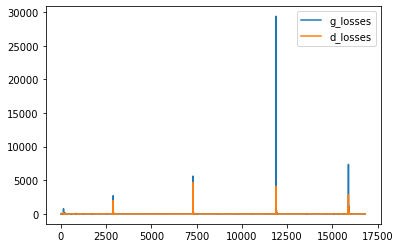

In [13]:
plt.plot(g_losses, label="g_losses")
plt.plot(d_losses, label='d_losses')
plt.legend()

### Co dalej ? - dla zainteresowanych 

 - Funkcje straty dla generatora
 - Wasserstein GAN (WGAN) - praca adresująca problem stabilności treningu, proponuje ona wykorzystanie funkcji straty bazującej na Wasserstein 1/Earth-Mover distance (EMD)
 - Conditional GAN (CGAN)- praca adresująca problem przypadkowości generowanej kategorii poprzez narzucanie warunku w postaci wektora (one-hot-encoded)
 - Least Squares GAN (LSGAN) - adresuje problem opisane w WGAN oraz dodaje elementy poprawiające jakość wizualną generowanych zdjęć
 - Auxiliary Classifier GAN (ACGAN) - usprawnione LSGAN + CGAN
 - Cycle GAN - transfer stylu
 - InfoGAN
 - Big GAN - stabilizacja
 - Progressive Growing GAN - stabilny trening obrazów w wysokiej rozdzielczości
 - StyleGAN - modyfikacje generatora, inteligentne generowanie wektora ukrytego
 - StyleGAN + Progressive Growing GAN = `state-of-the-art`